In [4]:
import numpy as np
import matplotlib
matplotlib.rcParams['image.cmap'] = 'jet'
import matplotlib.pyplot as plt
from numba import jit

# Домашнее Задание 2.
Дедлайн - 15 апреля

Форма сдачи - jupyter notebook. Классрум - https://classroom.google.com/c/NjYxNjY4MjY3NDIw?cjc=pho754c

P.S Пожалуйста, аккуратно оформляйте графики, ориентироваться можно на этот [материал](https://github.com/esokolov/ml-course-hse/blob/master/2022-fall/seminars/sem02-charts.ipynb). У графиков обязательно должно быть:

- Название
- Подписанные оси
- Легенда, если необходимо (например, если несколько цветов на одном графике)
- Все должно быть четко видно и ничего не сливаться
- Непонятные и неаккуратные графики могут негативно сказаться на оценке

Также нельзя использовать готовые решения задач: например, если вам нужно решить СЛУ, то запрещено использовать [numpy.linalg.solve](https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html), иначе 0 баллов. За неэффективное использование циклов также могут быть нежелательным - используйте векторные операции.

Все задачи весят одинаково.

# Задача 0.

В прикладных задачах нередко возникают ситуации, когда матрица  имеет очень много нулевых значений (разреженная матрица). Тогда хранить ее в обычном виде бывает затратно по потребляемой памяти. Для таких матриц существуют различные виды представлений, разберем один из них - COO (Coordinate Format), в котором храним тройки (строка, столбец, значение) для каждого ненулевого элемента

Например, матрица
$$
\begin{pmatrix}
1 & 0 & 0 & 0\\
0 & 0 & 2 & 0\\
3 & 0 & 0 & 4
\end{pmatrix}
$$
 

будет иметь вид COO: (нумерация с $0$)

- Массив строк `row_indexes = [0, 1, 2, 2]`
- Массив столбцов `col_indexes = [0, 2, 0, 3]`
- Массив значений `values = [1, 2, 3, 4]`

В данной задаче нужно реализовать класс `Sparse` для разреженных матриц. Запрещено использовать готовые решения, циклы тоже.
Вам могут понадобиться следующие методы, но можете использовать шаблон по своему усмотрению. Главное сохраните общий вид

In [5]:
class Sparse:

    def __init__(self, rows: np.ndarray, cols: np.ndarray, values: np.ndarray):
        self.rows = rows
        self.cols = cols
        self.values = values

    def multiply(self, vector: np.ndarray) -> np.ndarray:
        """
        Performs matrix-vector multiplication with a given vector.

        Args:
            vector (np.ndarray): The vector to be multiplied with the sparse matrix.

        Returns:
            np.ndarray: The result of the multiplication.
        """
        result_length = np.max(self.rows) + 1
        result = np.zeros(result_length)

        for i in range(len(self.values)):
            result[self.rows[i]] += self.values[i] * vector[self.cols[i]]

        return result

    def transpose(self):
        """
        Returns the transpose of the sparse matrix.

        Returns:
            Sparse: The transpose of the sparse matrix.
        """
        return Sparse(self.cols, self.rows, np.copy(self.values))

    def get_row(self, row_index: int, col_slice: tuple[int]) -> np.ndarray:
        """
        Retrieves a specific row from the sparse matrix within the specified column slice.

        Args:
            row_index (int): The index of the row to retrieve.
            col_slice (tuple[int]): A tuple representing the start and end indices of the column slice.

        Returns:
            np.ndarray: The requested row.
        """
        start_col, end_col = col_slice
        row_result = np.zeros(end_col - start_col)
        
        row_mask = self.rows == row_index
        col_mask = (self.cols >= start_col) & (self.cols < end_col)
        valid_indices = np.where(row_mask & col_mask)[0]
        
        row_result[self.cols[valid_indices] - start_col] = self.values[valid_indices]

        return row_result

    def get_element(self, row_index: int, col_index: int):
        """
        Retrieves the value of a specific element in the sparse matrix.

        Args:
            row_index (int): The row index of the element.
            col_index (int): The column index of the element.

        Returns:
            float: The value of the specified element.
        """
        values_at_position = self.values[(self.rows == row_index) & (self.cols == col_index)]

        if values_at_position.size > 0:
            return values_at_position[0]
        else:
            return 0.0

    def to_dense(self):
        """
        Converts the sparse matrix to a dense matrix.

        Returns:
            np.ndarray: The dense matrix representation of the sparse matrix.
        """
        dense_matrix = np.zeros((np.max(self.rows) + 1, np.max(self.cols) + 1))
        dense_matrix[self.rows, self.cols] = self.values

        return dense_matrix


In [33]:
# Тесты для самопроверки

rows = np.array([0, 1, 2, 2])
cols = np.array([0, 1, 1, 2])
values = np.array([3, 4, 5, 6])
sparse_matrix = Sparse(rows, cols, values)

# Умножение матрицы на вектор
vector = np.array([1, 2, 3])
result = sparse_matrix.multiply(vector)

assert vector.size == result.size
assert np.max(np.absolute(result - np.array([3, 8, 28]))) < 1.0e-30

# Получить строку по индексу строки и диапазону столбцов
row_index = 2
column_start = 0
column_end = 3
row = sparse_matrix.get_row(row_index, (column_start, column_end))
assert row.size == column_end - column_start

# Получить элемент по индексу строки и столбца
element = sparse_matrix.get_element(2, 1)
assert abs(element - 5) < 1.0e-30

assert np.max(np.absolute(sparse_matrix.to_dense() - np.array([[3., 0., 0.],[0., 4., 0.],[0., 5., 6.]]))) < 1.0e-30

В следующих 3 заданиях используйте ваш реализованный класс для разреженных матриц

# Задача 1.
Релизуйте алгоритм решения системы линейных уравнений методом би-сопряженных градиентов для разреженных матриц.
Протестируйте его на задаче, описанной в функции `test_problem_1`.

Фукнции, требующие модификации содержат комментарий:
"НЕОБХОДИМО ПРИВЕСТИ К ФОРМАТУ РАЗРЕЖЕННЫХ МАТРИЦ".

In [50]:
def init_system_matrix_1d_problem_task_1(nx, nt):
    dt = 1.0 / nt
    dx = 1.0 / nx
    coef = dt / dx / dx
    
    main_diagonal_values = np.full(nx, 1.0 + coef)
    main_diagonal_values[0] = 1.0 + 0.5 * coef
    main_diagonal_values[-1] = 1.0 + 0.5 * coef

    off_diagonal_values = np.full(nx - 1, -0.5 * coef)

    main_diagonal_indices = np.arange(nx)
    upper_diagonal_indices = np.arange(1, nx)
    lower_diagonal_indices = np.arange(nx - 1)
    
    rows = np.concatenate([main_diagonal_indices, lower_diagonal_indices, upper_diagonal_indices])
    cols = np.concatenate([main_diagonal_indices, upper_diagonal_indices, lower_diagonal_indices])
    values = np.concatenate([main_diagonal_values, off_diagonal_values, off_diagonal_values])

    return Sparse(rows, cols, values)

def init_right_part_task_1(nx):
    xnode = np.linspace(0.5 / nx, 1.0 - 0.5 / nx, nx)
    b = 0.2 + 1.6 * np.cos(2.0 * np.pi * xnode) - 0.2 * np.sin(1.0 * np.pi * xnode)
    return b

Алгоритм бисопряженных градиентов без предобуславливания

In [51]:
def init_bcg(smat, y):
    x0 = np.zeros(y.shape)
    r0 = y - smat.multiply(x0)
    rh0 = r0.copy()
    d0 = r0.copy()
    dh0 = d0.copy()
    return x0, r0, rh0, d0, dh0

def single_step_bcg(smat, x0, r0, d0, rh0, dh0):
    v0 = smat.multiply(d0)
    vh0 = smat.transpose().multiply(dh0)
    
    alpha = np.dot(rh0, r0) / np.dot(v0, dh0)
    x1 = x0 + alpha * d0

    r1 = r0 - alpha * v0
    rh1 = rh0 - alpha * vh0

    beta = np.dot(rh1, r1) / np.dot(rh0, r0)

    d1 = r1 + beta * d0
    dh1 = rh1 + beta * dh0
    return x1, r1, rh1, d1, dh1

def compute_solution_bcg_sparse(smat, bvec, niter):
    x0, r0, rh0, d0, dh0 = init_bcg_sparse(smat, bvec)
    res = np.zeros(niter + 1)

    for kiter in range(niter):
        res[kiter] = np.sqrt(np.dot(r0, r0))
        x1, r1, rh1, d1, dh1 = single_step_bcg_sparse(smat, x0, r0, d0, rh0, dh0)
        x0 = x1.copy()
        r0 = r1.copy()
        d0 = d1.copy()
        rh0 = rh1.copy()
        dh0 = dh1.copy()

    res[niter] = np.sqrt(np.dot(r0, r0))
    return x0, r0, res

test_problem_1


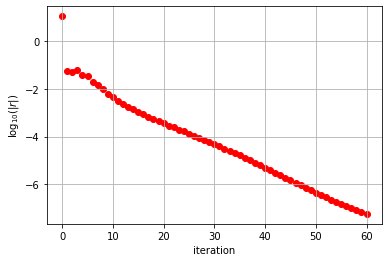

In [52]:
def test_problem_1():
    print('test_problem_1')
    nx = 80  # размерность пространства
    nt = 600  # параметр, контролирующий вид матрицы системы линейных уравнений
    niter = 60  # число итераций по методу би-сопряженнх градиентов
    smat = init_system_matrix_1d_problem_task_1(nx, nt)
    bvec = init_right_part_task_1(nx)

    # данную функцию надо реализовать
    u, r, res_norm = compute_solution_bcg(smat, bvec, niter)

    # график с десятичным логарифмом модуля вектора невязки
    plt.figure()
    plt.scatter(range(len(res_norm)), np.log10(res_norm), c='r')
    plt.xlabel('iteration')
    plt.ylabel(r'$\log_{10}(|r|)$')
    plt.grid()
    plt.show()

test_problem_1()